## Model I

* **Norms**: McRae et al. (2005)
* **Model**: Dinu & Lapata (2010) Extension 1
    * Topic Modeling for Properties: $p(prop\mid topic) = \sum_{word\in topic}p(word\mid topic)f(word,prop)$, where $f(word,prop) = \begin{cases}1 & \text{if word has prop}\\ 0 & otherwise\end{cases}$.
    * Word Property: $p(prop\mid word) = \sum_{topic}p(prop\mid topic)p(topic\mid word)p(word) = \sum_{topic}p(prop\mid topic)p(word\mid topic)p(topic)$.
    * New Word Property I: Paradigmatic Cohort Technique: 
        * Find $new\_word$'s predicate,
        * Find the set of $new\_word$'s paradigmatic cohort wrt. the predict,
        * The updated property is the intersection of all the properties of the words in the cohort.
    * New Word Property II: Syntagmatic Cohort Technique (TODO):
    * Evaluation

## 0. Norms

In [2]:
import numpy as np
import pandas as pd

In [3]:
data_path = "/Users/jacobsw/Desktop/CODER/IMPLEMENTATION_CAMP/BASIC_TOPICS/DISTRIBUTIONAL_SEMANTICS/DATA/McRae-BRM-InPress/"

In [4]:
df = pd.read_csv(data_path+"CONCS_FEATS_concstats_brm.xls", delimiter='\t')

In [5]:
df.columns

Index([u'Concept', u'Feature', u'WB_Label', u'WB_Maj', u'WB_Min', u'BR_Label',
       u'Prod_Freq', u'Rank_PF', u'Sum_PF_No_Tax', u'CPF', u'Disting',
       u'Distinct', u'CV_No_Tax', u'Intercorr_Str_Tax',
       u'Intercorr_Str_No_Tax', u'Feat_Length_Including_Spaces', u'Phon_1st',
       u'KF', u'ln(KF)', u'BNC', u'ln(BNC)', u'Familiarity', u'Length_Letters',
       u'Length_Phonemes', u'Length_Syllables', u'Bigram', u'Trigram',
       u'ColtheartN', u'Num_Feats_Tax', u'Num_Feats_No_Tax',
       u'Num_Disting_Feats_No_Tax', u'Disting_Feats_%_No_Tax',
       u'Mean_Distinct_No_Tax', u'Mean_CV_No_Tax', u'Density_No_Tax',
       u'Num_Corred_Pairs_No_Tax', u'%_Corred_Pairs_No_Tax', u'Num_Func',
       u'Num_Vis_Mot', u'Num_VisF&S', u'Num_Vis_Col', u'Num_Sound',
       u'Num_Taste', u'Num_Smell', u'Num_Tact', u'Num_Ency', u'Num_Tax'],
      dtype='object')

In [6]:
df.head()

,Concept,Feature,WB_Label,WB_Maj,WB_Min,BR_Label,Prod_Freq,Rank_PF,Sum_PF_No_Tax,CPF,...,Num_Func,Num_Vis_Mot,Num_VisF&S,Num_Vis_Col,Num_Sound,Num_Taste,Num_Smell,Num_Tact,Num_Ency,Num_Tax
0,accordion,a_musical_instrument,superordinate,c,h,taxonomic,28,1,NaN,18,...,2,0,2,0,2,0,0,0,2,1
1,accordion,associated_with_polkas,associated_entity,s,e,encyclopaedic,9,4,9.0,1,...,2,0,2,0,2,0,0,0,2,1
2,accordion,has_buttons,external_component,e,ce,visual-form_and_surface,8,5,163.0,13,...,2,0,2,0,2,0,0,0,2,1
3,accordion,has_keys,external_component,e,ce,visual-form_and_surface,17,2,108.0,7,...,2,0,2,0,2,0,0,0,2,1
4,accordion,inbeh_-_produces_music,entity_behavior,e,b,sound,6,7,178.0,13,...,2,0,2,0,2,0,0,0,2,1


In [7]:
norms = list(set(df['Concept']))

##### Are all norms in Brown?

In [22]:
from nltk.corpus import brown
from string import punctuation as punc
from spacy.en import English, STOPWORDS

In [15]:
from collections import defaultdict, Counter

In [12]:
brown_words = list(brown.words())

In [16]:
brown_fdist = Counter(brown_words)

In [393]:
brown_sents = [unicode(' '.join(sent)) for sent in brown.sents()]
parser = English()

In [394]:
def get_vocab_info(sents, parser):
    
    parsed_sents = [parser(sent) for sent in sents]
    token_set = {token.orth_ for parsed_sent in parsed_sents for token in parsed_sent}
    lemma_set = {token.lemma_ for parsed_sent in parsed_sents for token in parsed_sent}
    lemma2pos = defaultdict(set)
    token2pos = defaultdict(set)
    token2lemma = {}
    for parsed_sent in parsed_sents:
        for token in parsed_sent:
            lemma2pos[token.lemma_].add(token.pos_)
            token2pos[token.orth_].add(token.pos_)
            token2lemma[token.orth_] = token.lemma_
    
    return token_set, token2pos, lemma_set, lemma2pos, token2lemma

In [395]:
%%time
brown_tokens, brown_t2p, brown_lemmas, brown_l2p, brown_t2l = get_vocab_info(brown_sents, parser)

CPU times: user 1min 41s, sys: 446 ms, total: 1min 41s
Wall time: 1min 41s


##### Norm Standardization

In [215]:
def norm_cleanup(norms, corpus_tokens=brown_tokens, corpus_lemmas=brown_lemmas, corpus_t2l=brown_t2l):
    
    for i,norm in enumerate(norms):
        if '_' in norm: 
            norm = norm.split('_')[0]
            norms[i] = norm
        if norm in corpus_lemmas: pass
        elif norm in corpus_tokens:
            norms[i] = corpus_t2l[norm]
        else: pass
        
    return norms
    

In [217]:
features = list(set(df['Feature'])) # i.e. properties

In [220]:
def make_norm2feature_dict(df):
    
    norm2feature = defaultdict(int)
    for i in xrange(len(df)):
        norm = norm_cleanup([df.ix[i]['Concept']])[0]
        feature = df.ix[i]['Feature']
        norm2feature[(norm,feature)] += 1
    
    return norm2feature


In [221]:
norm2feature = make_norm2feature_dict(df)

## I. Model 1

### A. Topic Modeling for Properties

* $p(prop\mid topic) = \sum_{word\in topic}p(word\mid topic)f(word,prop)$, where $f(word,prop) = \begin{cases}1 & \text{if word has prop}\\ 0 & otherwise\end{cases}$.

** a. Facilities (Gensim) **

In [44]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [145]:
class TopicModel:
    
    def __init__(self, documents, num_topics=3, num_iters=10):
        dic = corpora.Dictionary(documents)
        documents = [dic.doc2bow(document) for document in documents]
        self.documents = documents
        self.lda = LdaModel(documents, num_topics=num_topics, id2word=dic, passes=num_iters)
    
    def summarize(self, num_topics=3, num_words=5):
        freq_stats = self.lda.print_topics(num_topics=num_topics, num_words=num_words)
        print "Statistics"
        print 
        for i,document in enumerate(self.documents):
            print "Most %d-Frequent Words in Topic %d:" % (num_words,freq_stats[i][0])
            print freq_stats[i][1]
            print "Topic-Distribution:"
            print self.lda.get_document_topics(document)
            print

** b. Make DL10 Fake Documents **

In [81]:
brown_sents = list(brown.sents())

In [106]:
def tokensent2lemmasent(sents, fdist, norms, freq=20):
    
    parsed_sents = [parser(unicode(' '.join(sent))) for sent in sents]
    sents_in_lemmas = []
    for parsed_sent in parsed_sents:
        sent = []
        for token in parsed_sent:
            if token.orth_ in norms or token.lemma_ in norms:
                sent.append(token.lemma_)
            elif fdist[token.orth_] < freq \
                or token.lemma_ in STOPWORDS \
                or token.lemma_ in punc: continue
            else: 
                sent.append(token.lemma_)
        sents_in_lemmas.append(sent)
    
    return sents_in_lemmas

In [96]:
def get_norm_fdist(norms, fdist, t2l):
    
    ret = []
    for norm in norms:
        if norm in fdist:
            ret.append((norm,fdist[norm]))
        elif norm in t2l:
            norm = t2l[norm]
            if norm in fdist: 
                ret.append((norm,fdist[norm]))
    
    return ret

In [97]:
norm_fdist = get_norm_fdist(norms, brown_fdist, brown_t2l)

In [103]:
norms_set = set(norms) # for quickening 'in norms' check.

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

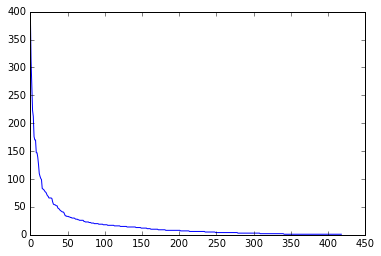

In [109]:
plt.plot(sorted([count for norm,count in norm_fdist], reverse=True))
plt.show()

In [108]:
%%time
brown_sents = tokensent2lemmasent(brown_sents, brown_fdist, norms_set)

CPU times: user 1min 20s, sys: 198 ms, total: 1min 21s
Wall time: 1min 20s


In [110]:
vocab = {word for sent in brown_sents for word in sent}

In [117]:
len(vocab)

3992

In [118]:
len([norm for norm in norms if norm not in vocab]) # out of vocab norms

79

In [121]:
def build_cooccurrence_matrix(sents, vocab, win_size):
    
    w2i = {w:i for i,w in enumerate(vocab)}
    print "... building dictionary"
    cooccurrence_dict = defaultdict(int)
    for sent in sents:
        for i,target in enumerate(sent):
            contexts = sent[max(0,i-win_size):i] + sent[min(i+1,len(sent)):min(i+1+win_size,len(sent))]
            for context in contexts:
                cooccurrence_dict[(target,context)] += 1
    print "... building cooccurrence matrix"
    cooccurrence_matrix = np.zeros((len(vocab),len(vocab)))
    for target in vocab:
        for context in vocab:
            cooccurrence_matrix[w2i[target]][w2i[context]] += cooccurrence_dict[(target,context)]
    
    return w2i, cooccurrence_matrix

In [122]:
%%time
w2i, cooccurrence_matrix = build_cooccurrence_matrix(brown_sents, vocab, 2)

... building dictionary
... building cooccurrence matrix
CPU times: user 22.7 s, sys: 1.85 s, total: 24.6 s
Wall time: 24 s


In [124]:
import cPickle

In [126]:
# path = "/Users/jacobsw/Desktop/UNIV/FALL_2016/LIN389C_RSCH_COMPLING/BAYESIAN/CODE_DRAFTS/DATA/"
# cPickle.dump(cooccurrence_matrix, open(path+"coccurrence_matrix.p",'wb'))
# coocurrence_matrix = cPickle.load(open(path+"coccurrence_matrix.p",'rb'))

In [324]:
# def make_fake_documents(matrix, vocab):
    
#     docs = []
#     for i,row in enumerate(matrix):
#         if i!=0 and i%1000==0: print "... processed %d targets." % i
#         doc = []
#         for j,cell in enumerate(row): # cell (i,j) count.
#             doc += [vocab[j]] * cell
#         docs.append(doc)
    
#     return docs

def make_fake_documents(matrix, vocab):
    
    docs = []
    m, n = matrix.shape
    for i in xrange(m):
        if i!=0 and i%1000==0: print "... processed %d targets." % i
        doc = []
        for j in xrange(n): 
            doc += [vocab[j]] * matrix[i][j]
        docs.append(doc)
    
    return docs

In [328]:
i2w = {i:w for w,i in w2i.iteritems()}

In [329]:
%%time
docs = make_fake_documents(cooccurrence_matrix, i2w)

... processed 1000 targets.
... processed 2000 targets.
... processed 3000 targets.
CPU times: user 30.6 s, sys: 1.49 s, total: 32.1 s
Wall time: 31.1 s


In [332]:
# cPickle.dump(docs, open(path+"fake_documents.p",'wb'))
# docs = cPickle.load(open(path+"fake_documents.p",'rb'))

In [335]:
print i2w[1]
print docs[1]

limited
[u'child', u'risk', u'govern', u'force', u'study', u'study', u'credit', u'total', u'involve', u'involve', u'want', u'thing', u'provide', u'provide', u'provide', u'parallel', u'devote', u'production', u'free', u'free', u'playing', u'struggle', u'fiction', u'project', u'matter', u'manner', u'shall', u'earth', u'adequate', u'despite', u'future', u'future', u'extent', u'protection', u'skill', u'life', u'procedure', u'suggest', u'social', u'possible', u'possible', u'old', u'successfully', u'support', u'way', u'way', u'war', u'war', u"''", u"''", u"''", u'generally', u'realize', u'painting', u'daily', u'time', u'time', u'people', u'people', u'people', u'choice', u'discover', u'assistance', u'assistance', u'assistance', u'extra', u'merely', u'today', u'``', u'``', u'``', u'effort', u'discussion', u'vital', u'man', u'man', u'explicit', u'nation', u'half', u'2', u'2', u'white', u'population', u'ground', u'slow', u'resource', u'artist', u'relative', u'federal', u'period', u'direction', u

** c. Topic Modeling on Fake Docs **

In [336]:
%%time
tm = TopicModel(docs, num_topics=100, num_iters=5)

CPU times: user 2min 7s, sys: 2.06 s, total: 2min 9s
Wall time: 2min 8s


In [337]:
# cPickle.dump(tm, open(path+"topic_model.p",'wb'))
# tm = cPickle.load(open(path+"topic_model.p",'rb'))

In [345]:
tm.lda.get_document_topics(tm.documents[0])

[(20, 0.3883246604863429), (49, 0.53629072412904299)]

In [346]:
tm.lda.get_topic_terms(0)

[(98, 0.013330662998430783),
 (3678, 0.012625443555063431),
 (191, 0.011901291855010704),
 (1093, 0.011480955669982853),
 (228, 0.010758324296336618),
 (533, 0.0088845763781074394),
 (138, 0.008465844931493223),
 (439, 0.008383028928491295),
 (276, 0.0078938102793168884),
 (412, 0.007718434693532613)]

In [347]:
tm.lda.id2word[645]

u'watch'

In [348]:
tm_i2w = {i:w for i,w in tm.lda.id2word.iteritems()}
tm_w2i = {w:i for i,w in tm.lda.id2word.iteritems()}

In [349]:
def make_topic_word_dict(lda, ntopics=100):
    
    nwords = lda.num_terms
    i2w = lda.id2word
    topicword_dict = defaultdict(float)
    for i in xrange(ntopics):
        for w_id,prob in lda.get_topic_terms(i,topn=nwords):
            topicword_dict[(i,i2w[w_id])] = prob
    
    return topicword_dict

In [350]:
%%time
topicword_dict = make_topic_word_dict(tm.lda)

CPU times: user 717 ms, sys: 39.8 ms, total: 757 ms
Wall time: 751 ms


In [352]:
topicword_dict[(0,'cat')]

1.867030818011924e-06

In [353]:
def p_word_given_topic(word, topic):
    return topicword_dict[(topic,word)]

In [354]:
def f_word_prop(word, prop):
    return norm2feature[(word,prop)]

In [356]:
print p_word_given_topic('cat',0)
print f_word_prop('accordion','a_musical_instrument')

1.86703081801e-06
1


In [357]:
def make_topic_prop_dict(lda, ntopics=100):
    
    nwords = lda.num_terms
    i2w = lda.id2word
    topicprop_dict = defaultdict(float)
    for i in xrange(ntopics):
        if i!=0 and i%5==0: print "... processed %d topics." % i
        for prop in features: # features defined at the top.
            ret = 0.0
            for w_id,prob in lda.get_topic_terms(i,topn=nwords):
                word = i2w[w_id]
                ret += p_word_given_topic(word,i)*f_word_prop(word,prop)
            topicprop_dict[(i,prop)] = ret
    
    return topicprop_dict


In [358]:
%%time
topicprop_dict = make_topic_prop_dict(tm.lda)

... processed 5 topics.
... processed 10 topics.
... processed 15 topics.
... processed 20 topics.
... processed 25 topics.
... processed 30 topics.
... processed 35 topics.
... processed 40 topics.
... processed 45 topics.
... processed 50 topics.
... processed 55 topics.
... processed 60 topics.
... processed 65 topics.
... processed 70 topics.
... processed 75 topics.
... processed 80 topics.
... processed 85 topics.
... processed 90 topics.
... processed 95 topics.
CPU times: user 45min 39s, sys: 6.88 s, total: 45min 46s
Wall time: 45min 46s


In [359]:
# cPickle.dump(topicprop_dict, open(path+"topicprop_dict.p",'wb'))
# topicprop_dict = cPickle.load(open(path+"topicprop_dict.p",'rb'))

In [360]:
def p_prop_given_topic(prop, topic):
    return topicprop_dict[(topic,prop)]

### B. Word Properties

* $p(prop\mid word) = \sum_{topic}p(prop\mid topic)p(topic\mid word)p(word) = \sum_{topic}p(prop\mid topic)p(word\mid topic)p(topic)$.
* NB: $p(prop\mid topic)p(topic\mid word)p(word) = \frac{p(word\mid topic)p(topic)}{p(word)}p(word) = p(word\mid topic)p(topic)$.

In [375]:
from __future__ import division
from heapq import nlargest

In [362]:
words = [word for doc in docs for word in doc]
nwords = len(words)
word_counts = Counter(words)

In [253]:
# def make_wordprop_dict(ntopics=100):
    
#     p_topic = 1/ntopics
#     wordprop_dict = defaultdict(float)
#     for n,word in enumerate(words):
#         if n!=0 and n%500==0: 
#             print "... processed %d words." % n
#             break
#         for prop in features:
#             ret = 0.0
#             for i in xrange(ntopics):
#                 ret += p_prop_given_topic(prop,i)*p_word_given_topic(word,i)*p_topic
#             wordprop_dict[(word,prop)] = ret
    
#     return wordprop_dict

# %%time
# wordprop_dict = make_wordprop_dict()
# ... processed 500 words.
# CPU times: user 1min 43s, sys: 135 ms, total: 1min 43s
# Wall time: 1min 43s

# ~ 70.8 hrs to run all.

In [363]:
def p_prop_given_word(prop, word, ntopics=100):
    
    p_topic = 1/ntopics
    ret = 0.0
    for i in xrange(ntopics):
        ret += p_prop_given_topic(prop,i)*p_word_given_topic(word,i)*p_topic
        
    return ret

In [493]:
def top_k_prop(word, k=10, verbose=1):
    
    props = [(i,p_prop_given_word(prop,word)) for i,prop in enumerate(features)]
    top_k = nlargest(k, props, key=lambda x:x[1])
    if verbose:
        for i,(idx,prob) in enumerate(top_k):
            print "%dth property: %s (prob=%.6f%%)." % (i+1,features[idx],prob*100)
    
    top_k_props = map(lambda (idx,prob): features[idx], top_k)
    
    return set(top_k_props)
        

In [494]:
top_k_prop('book')

1th property: is_large (prob=0.001054%).
2th property: made_of_metal (prob=0.001035%).
3th property: made_of_wood (prob=0.000965%).
4th property: is_long (prob=0.000698%).
5th property: found_in_schools (prob=0.000657%).
6th property: used_for_learning (prob=0.000657%).
7th property: is_small (prob=0.000589%).
8th property: made_of_plastic (prob=0.000570%).
9th property: made_of_paper (prob=0.000557%).
10th property: has_pictures (prob=0.000527%).


{'found_in_schools',
 'has_pictures',
 'is_large',
 'is_long',
 'is_small',
 'made_of_metal',
 'made_of_paper',
 'made_of_plastic',
 'made_of_wood',
 'used_for_learning'}

In [495]:
top_k_prop('alligator')

1th property: made_of_wood (prob=0.000050%).
2th property: is_large (prob=0.000044%).
3th property: is_small (prob=0.000044%).
4th property: made_of_metal (prob=0.000043%).
5th property: an_animal (prob=0.000040%).
6th property: is_round (prob=0.000029%).
7th property: has_4_legs (prob=0.000027%).
8th property: is_long (prob=0.000025%).
9th property: is_edible (prob=0.000025%).
10th property: has_legs (prob=0.000024%).


{'an_animal',
 'has_4_legs',
 'has_legs',
 'is_edible',
 'is_large',
 'is_long',
 'is_round',
 'is_small',
 'made_of_metal',
 'made_of_wood'}

### C. New Word Properties

* a. ** New Word Property I: Paradigmatic Cohort Technique **: 
    * Find $new\_word$'s predicate,
    * Find the set of $new\_word$'s paradigmatic cohort wrt. the predict,
    * The updated property is the intersection of all the properties of the words in the cohort.

**NB**: May not work.

In [410]:
t = u'i ate a cat that attacks cats.'
parsed_t = parser(t)
for token in parsed_t:
    print '(', token.lemma_, '|', token.dep_, '|', token.head.lemma_, ')'

( i | nsubj | eat )
( eat | ROOT | eat )
( a | det | cat )
( cat | dobj | eat )
( that | nsubj | attack )
( attack | relcl | cat )
( cat | dobj | attack )
( . | punct | eat )


In [404]:
def get_prop(word, k=10):
    
    props = [(i,p_prop_given_word(prop,word)) for i,prop in enumerate(features)]
    top_k = nlargest(k, props, key=lambda x:x[1])
    
    return {features[idx] for idx,prop in top_k}
    

In [407]:
print get_prop('book')

set(['found_in_schools', 'made_of_paper', 'made_of_metal', 'is_long', 'made_of_plastic', 'used_for_learning', 'is_small', 'has_pictures', 'is_large', 'made_of_wood'])


In [431]:
def get_pred_args(parsed_sent):
    
    pred_args = defaultdict(lambda : defaultdict(set))
    for token in parsed_sent: 
        if token.dep_.endswith('subj'):
            pred_args[token.head.lemma_]['S'].add(token.lemma_)
        elif token.dep_.endswith('obj'):
            pred_args[token.head.lemma_]['O'].add(token.lemma_)
    
    return pred_args
        

In [412]:
get_pred_args(parsed_t)

defaultdict(<function __main__.<lambda>>,
            {u'attack': defaultdict(set, {'O': {u'cat'}, 'S': {u'that'}}),
             u'eat': defaultdict(set, {'O': {u'cat'}, 'S': {u'i'}})})

In [425]:
%%time
sents = [unicode(' '.join(sent)) for sent in brown.sents()]
parsed_sents = [parser(sent) for sent in sents]

CPU times: user 1min 28s, sys: 170 ms, total: 1min 28s
Wall time: 1min 28s


In [450]:
def extract_dep_triples(parsed_sents):
    
    triples = []
    for parsed_sent in parsed_sents:
        for token in parsed_sent:
            token_triple = (token.orth_, token.dep_, token.head.orth_) # may be useful later.
            lemma_triple = (token.lemma_, token.dep_, token.head.lemma_)
            triples.append([token_triple, lemma_triple])
    
    return triples

In [452]:
%%time
dep_triples = extract_dep_triples(parsed_sents)

CPU times: user 7.01 s, sys: 465 ms, total: 7.48 s
Wall time: 7.44 s


In [464]:
def make_para_cohort_dict(triples): 
    
    para_dict = defaultdict(lambda : defaultdict(set))
    for token_triples,lemma_triples in triples:
        if token_triples[1].endswith('subj'):
            para_dict[lemma_triples[2]]['S'].add(lemma_triples[0])
        elif token_triples[1].endswith('obj'):
            para_dict[lemma_triples[2]]['O'].add(lemma_triples[0])
    
    return para_dict
    

In [465]:
%%time
para_dict = make_para_cohort_dict(dep_triples)

CPU times: user 1.15 s, sys: 32.2 ms, total: 1.18 s
Wall time: 1.16 s


In [468]:
print para_dict['copy']
print para_dict['eat']

defaultdict(<type 'set'>, {'S': set([u'constitution']), 'O': set([u'message', u'much', u'them', u'child'])})
defaultdict(<type 'set'>, {'S': set([u'student', u'people', u'fish', u'it', u'one', u'americans', u'which', u'lord', u'you', u'we', u'animal', u'parent', u'who', u'dave', u'they', u'child', u'gasp', u'he', u'boy', u'i', u'charlie', u'she']), 'O': set([u'tamale', u'garbage', u'flesh', u'it', u'dust', u'seed', u'skin', u'breakfast', u'chicken', u'what', u'profit', u'facility', u'dinner', u'celery', u'other', u'enough', u'much', u'bread', u'hat', u'rider', u'more', u'body', u'leg', u'food', u'luncheon', u'fat', u'cereal', u'supper', u'nothing', u'man', u'stress', u'piece', u'salad', u'this', u'amount', u'soup', u'portion', u'daisy', u'mussel', u'litle', u'egg', u'meal'])})


In [514]:
def nonzero_prop(word):
    
    props = [(i,p_prop_given_word(prop,word)) for i,prop in enumerate(features)]  
    nonzeros = map(lambda (idx,prob):features[idx], props)
    
    return set(nonzeros)
    

In [536]:
def infer_para_prop(word, pred, rel, k=300):
    
    para_cohort = list(para_dict[pred][rel])
    prop_list = map(lambda word: top_k_prop(word,k,verbose=0), para_cohort)
    prop_intersection = set.intersection(*prop_list)
    
    return prop_intersection


In [537]:
l = infer_para_prop('cat','eat','S')

In [538]:
l

{'a_bird',
 'a_carnivore',
 'has_a_beak',
 'is_loud',
 'is_red',
 'lives_in_wilderness',
 'made_of_cement',
 'made_of_glass',
 'tastes_good',
 'used_for_transportation',
 'worn_by_women'}